In [14]:
# Start building the Auto encoder
# Import neccesary libraries
from keras.callbacks import TensorBoard
from keras import Sequential
from keras .callbacks import TensorBoard
from keras.models import Model
from keras import Input,layers
from keras.utils import to_categorical
from keras.layers import Conv2D,UpSampling2D,MaxPooling2D,ZeroPadding2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from sklearn.model_selection import train_test_split

from sklearn.metrics import average_precision_score,mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
#  Data Preprocessing
import os,shutil

#path to data
train_path = r"c:\Users\abulele\Desktop\Training_Data"

test_path = r"c:\Users\abulele\Desktop\Test_Data"

augment_data =r"c:\Users\abulele\Desktop\Training_Data\data_augmentation"


In [16]:

# normalize the images and Data Augmentation.
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=20,
    class_mode="input",
    shuffle=True
   )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150,150),
    batch_size=20,
    class_mode="input")

Found 4658 images belonging to 1 classes.
Found 2092 images belonging to 1 classes.


In [17]:
# Build an Auto encoder

## Auto encoders are unsupervised  machine learning models where  the target output (Y) is the input (X), therefore becomes model.fit(X,X)

### An auto encoder consists of three layers


#### 1. Encoder:
##### Encodes the input image or data as a compressed representation in a reduced dimension. The compressed image is the distorted version of the original  image.

In [18]:
from IPython.display import Image
Image(url='https://d1jnx9ba8s6j9r.cloudfront.net/blog/wp-content/uploads/2018/10/raisr-info-width-2000-528x297.png')  

#### 2. Code:
#####  Feeds the compressed image to the decoder.

#### 3. Decoder:
##### This layer decodes  the encoded image back to the original dimension.

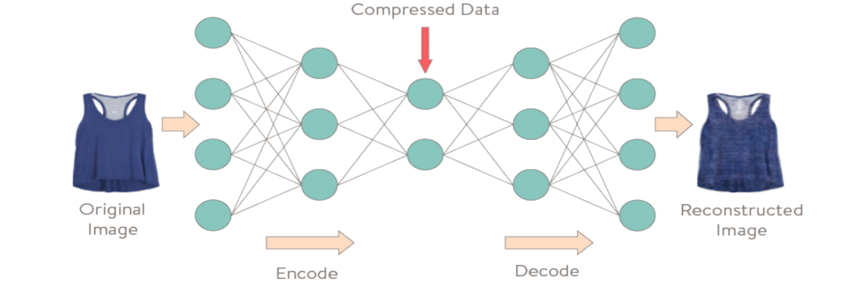




<h3 style="color:black;"> How will I use this ? </h1>
<br>
<ol> 
    <li> Train it on normal instances, so when we feed the model anomalies they will be easily detected </li>
    <br>
    <li> To classify new instances we  feed them to input of autoencoder</li>
    <br>
    <li> Get reconstruction error output and compute the resconstruction error</li>
    <br>
    <li> Measure the distance between the reconstructed output and input </li>
    
</ol>

In [19]:
# lets get building. This the Archictecture. A deep autoencoder

input_img = Input(shape=(150,150,3)) #  takes image 150X150 pixel with RGB 

X = Conv2D(16,(3,3), activation='relu',padding="same")(input_img)
X = MaxPooling2D((2,2), padding='same')(X)
X = Conv2D(8, (3,3), activation='relu',padding="same")(X)
X = MaxPooling2D((2,2), padding='same')(X)
X = Conv2D(8,(3,3), activation='relu', padding='same')(X)

# Compress the image
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(X)



# decoding. 
X = Conv2D(8,(3,3), activation='relu',padding="same")(encoded)
X = UpSampling2D((2,2))(X)
X = Conv2D(8, (3,3), activation='relu',padding="same")(X)
X = UpSampling2D((2,2))(X)

X = ZeroPadding2D(padding=(1, 1), input_shape=(148, 148, 16))(X)
X = Conv2D(16, (3, 3), activation='relu')(X)
X = UpSampling2D((2, 2))(X)




# decoding- decodes encoded image back to original 
decoded = Conv2D(3,(3,3),activation="sigmoid", padding='valid')(X)

In [20]:
#Lets define an encoder 

encoder = Model(input_img,encoded)

In [21]:
# define autoencoder 

autoencoder = Model(input_img, decoded) # Defined the model
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 19, 19, 8)         0         
__________

In [35]:
# Use Tensorboard to Monitor Model
from time import time


tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

In [ ]:
#  Training the autoencoder
    
#train the model   
autoencoder_train = autoencoder.fit_generator(generator=train_generator,steps_per_epoch=20,
                        epochs=30,validation_data=test_generator,
                         validation_steps=20,shuffle=True,
                        callbacks=[tensorboard]
                        )

Epoch 1/30
20/20 [==============================] - 27s 1s/step - loss: 0.0094 - val_loss: 0.0215
Epoch 2/30
20/20 [==============================] - 19s 957ms/step - loss: 0.0095 - val_loss: 0.0216
Epoch 3/30
20/20 [==============================] - 19s 958ms/step - loss: 0.0100 - val_loss: 0.0214
Epoch 4/30
20/20 [==============================] - 19s 962ms/step - loss: 0.0094 - val_loss: 0.0214
Epoch 5/30
20/20 [==============================] - 19s 965ms/step - loss: 0.0093 - val_loss: 0.0214
Epoch 6/30
19/20 [===========================>..] - ETA: 0s - loss: 0.0094

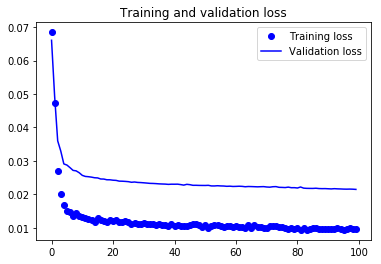

In [32]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()





In [ ]:
#Create the encoder 

encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)

encoder.save('encoder.h5')

In [ ]:
for data_batch, labels_batch in test_generator:
    print("data batch shape: ", data_batch.shape)
    print("labels batch shape: ", labels_batch.shape)
    break

In [ ]:
predictions = autoencoder.predict_generator(test_generator, 1)

In [ ]:
plt.figure(figsize=(17, 10))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(data_batch[i, ..., 0])
    curr_lbl = labels_batch[i]
    plt.title("input Images")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.title("constructed")
    plt.imshow(predictions[i, ..., 0])  
plt.show()

In [ ]:
autoencoder.save("autoencoders_train.h5")

In [ ]:



# Part two  
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(3, activation='sigmoid')(decoded)

In [ ]:
autoencoder2 = Model(input_img, decoded)
autoencoder2.compile(optimizer='adadelta', loss='mse')

autoencoder2.summary()

In [ ]:
autoencoder2.fit_generator(generator=train_generator,steps_per_epoch=20,
                        epochs=30,validation_data=test_generator,
                         validation_steps=2)